In [4]:
import matplotlib.pyplot as plt
import os
import seaborn as sns

import tensorflow as tf
import numpy as np

In [2]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/archive.zip or
        /content/archive.zip.zip, and cannot find /content/archive.zip.ZIP, period.


In [ ]:
# !pip install Pillow

In [ ]:
# !pip install opencv-python

In [ ]:
from PIL import Image
import cv2

In [ ]:
def example_generator():

    for annotation in [file_path for file_path in os.listdir("obj/") if file_path.endswith(".txt")]:

        with open(os.path.join("obj/", annotation), "r") as fp:
            lines = fp.readlines()
            if len(lines) > 1:
                continue

        try:
            image_path = os.path.join("obj/", annotation.replace(".txt", ".jpg"))
            assert os.path.isfile(image_path)
        except AssertionError:
            continue
        else:
            image = Image.open(image_path)
            image_numpy = np.asanyarray(image)

            metadata = lines[0].strip().split(" ")

            classification_label = int(metadata[0])
            regression_values = [float(data) for data in metadata[1:]]

        yield image_numpy, classification_label, regression_values

In [ ]:
gen = example_generator()

In [ ]:
dataset = tf.data.Dataset.from_generator(
     example_generator,
     output_signature=(
         tf.TensorSpec(shape=(None, None ,3), dtype=tf.float32),
         tf.TensorSpec(shape=(), dtype=tf.int32),
         tf.TensorSpec(shape=(4,), dtype=tf.float32)
     ),

)

In [ ]:
for b in dataset.take(1):
    print(b)

(<tf.Tensor: shape=(341, 324, 3), dtype=float32, numpy=
array([[[107., 105.,  93.],
        [108., 106.,  94.],
        [109., 107.,  95.],
        ...,
        [104.,  96.,  77.],
        [104.,  96.,  77.],
        [105.,  97.,  78.]],

       [[105., 103.,  91.],
        [106., 104.,  92.],
        [108., 106.,  94.],
        ...,
        [105.,  97.,  78.],
        [106.,  98.,  79.],
        [106.,  98.,  79.]],

       [[103., 101.,  89.],
        [105., 103.,  91.],
        [107., 105.,  93.],
        ...,
        [106.,  98.,  79.],
        [106.,  98.,  79.],
        [107.,  99.,  80.]],

       ...,

       [[ 33.,  30.,  23.],
        [ 28.,  25.,  18.],
        [ 24.,  21.,  14.],
        ...,
        [116.,  43.,  50.],
        [113.,  40.,  47.],
        [111.,  38.,  45.]],

       [[ 41.,  38.,  31.],
        [ 33.,  30.,  23.],
        [ 28.,  25.,  18.],
        ...,
        [114.,  41.,  48.],
        [111.,  38.,  45.],
        [110.,  37.,  44.]],

       [[ 48.,  

In [ ]:
dataset = (
    dataset
    .map(lambda image, classification_label, regression_label: (tf.image.resize(image, (224, 224)), classification_label, regression_label)))

In [ ]:
def yolobbox2bbox(x,y,w,h):
    x1, y1 = x-w/2, y-h/2
    x2, y2 = x+w/2, y+h/2
    return x1, y1, x2, y2

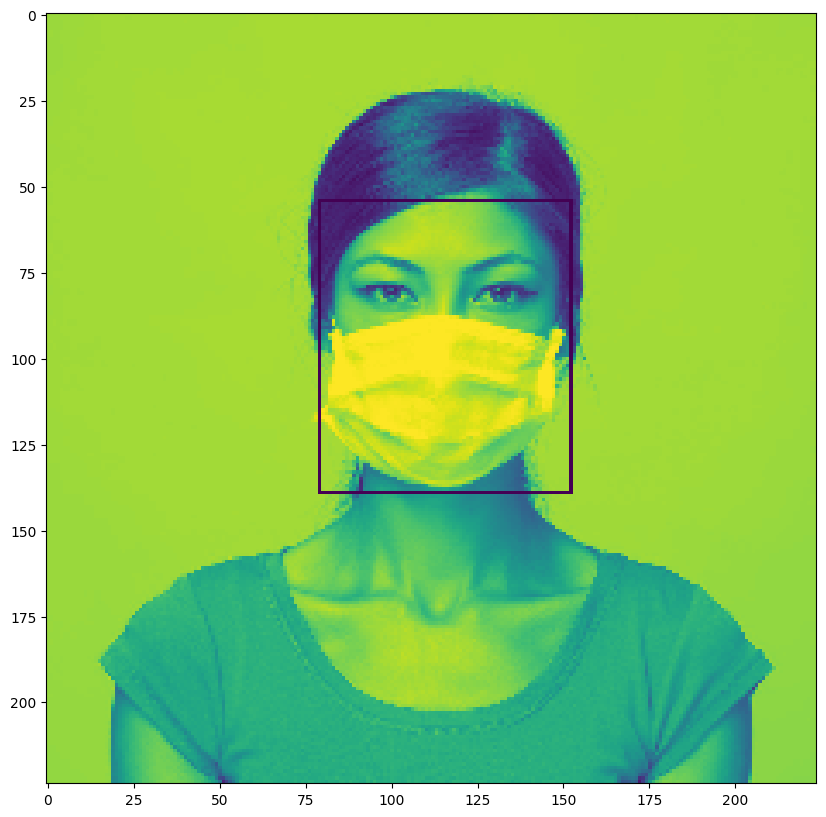

In [ ]:
plt.figure(figsize=(20, 10))
for image, label_1, label_2 in dataset.skip(10).take(1):
    # print(image)
    box = tf.cast(label_2 * 224, tf.int32).numpy()
    box = yolobbox2bbox(box[0], box[1], box[2], box[3])
    image_color = cv2.cvtColor(image.numpy(), cv2.COLOR_BGR2GRAY)
    cv2.rectangle(image_color, pt1=(int(box[0]), int(box[1])), pt2=(int(box[2]), int(box[3])), color=(0, 255, 0))
    plt.imshow(image_color)


In [ ]:
dataset = dataset.shuffle(1_000).batch(32).prefetch(5)

# Modelo

In [7]:
## Clasificador

inputs = tf.keras.layers.Input((224, 224, 3), dtype=tf.float32, name="INPUT_IMAGE")
rescaling = tf.keras.layers.Rescaling(1. / 255)(inputs)

# Augmentation ???


# Bloques convolucionales

conv_1 = tf.keras.layers.Conv2D(filters=16, kernel_size=3, padding="same", activation="relu", name="conv_1")(rescaling)
max_pool_1 = tf.keras.layers.MaxPool2D(name="max_pool_1")(conv_1)

conv_2 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", name="conv_2")(max_pool_1)
max_pool_2 = tf.keras.layers.MaxPool2D(name="max_pool_2")(conv_2)

conv_3 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", name="conv_3")(max_pool_2)
max_pool_3 = tf.keras.layers.MaxPool2D(name="max_pool_3")(conv_3)

x = tf.keras.layers.Flatten()(max_pool_3)
x = tf.keras.layers.Dropout(.5)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(.5)(x)

classification_head = tf.keras.layers.Dense(1, activation="sigmoid", name="classification_head")(x)
regression_head = tf.keras.layers.Dense(4, name="regression_head")(x)

model = tf.keras.Model(inputs=[inputs], outputs=[classification_head, regression_head], name="model")



